In [ ]:
#| default_exp fastspeech

# Fastspeech

In [ ]:
#| export
import torch
import torch.nn as nn
from torch import Tensor
from math import sqrt
from torch.nn import Module
import torch.nn.functional as F

In [ ]:
#| export
def get_positional_embeddings(seq_len, # The length of the sequence
                              d_model, # The hidden dimension of the model
                              device: torch.device =None): # Device you want to use
    pos = torch.arange(d_model, device=device)[None, :]
    i = torch.arange(seq_len, device=device)[:, None]
    angle = pos / torch.pow(10000, 2 * i / d_model)
    pos_emb = torch.zeros(angle.shape, device=device)
    pos_emb[0::2,:], pos_emb[1::2,:] = angle[0::2,:].sin(), angle[1::2,:].cos()
    return pos_emb

In [ ]:
#| export
def scaled_dot_product(query: Tensor, key: Tensor, value: Tensor, mask: bool = False) -> Tensor:
    key_dim = key.shape[-1]

    scores = (query @ key.transpose(-1, -2)) / sqrt(key_dim)
    
    if mask:
        scores_mask = torch.tril(torch.ones_like(scores))
        scores = scores.masked_fill(scores_mask==0, float('-inf'))
        
    return F.softmax(scores, dim=-1) @ value

In [ ]:
#| export
class AttentionHead(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, mask: bool = False) -> None:
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels*3, bias=False)
        self.mask = mask
    
    def forward(self, x: Tensor) -> Tensor:
        h = self.linear(x)
        query, key, value = torch.chunk(h, chunks=3, dim=-1)
        
        attention_scores = scaled_dot_product(query, key, value, self.mask)
        
        return attention_scores

In [ ]:
#| export
class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_heads: int, mask: bool = False) -> None:
        super().__init__()
        head_channels = in_channels // n_heads
        self.attention_heads = nn.ModuleList([AttentionHead(in_channels, head_channels, mask) 
                                              for _ in range(n_heads)])
        
        self.linear = nn.Linear(in_channels, out_channels)
    
    def forward(self, x: Tensor) -> Tensor:
        h = torch.cat([head(x) for head in self.attention_heads], dim=-1)
        
        return self.linear(h)

In [ ]:
#| export
def get_padding(ks: int, dilation: int = 1) -> int:
    return ((ks - 1) // 2) * dilation

In [ ]:
#| export
def conv(in_channels: int, out_channels: int, ks: int, Activation: Module = None, **kwargs) -> Module:
    layers = [nn.Conv1d(in_channels, out_channels, ks, **kwargs)]
    if Activation is not None:
        layers.append(Activation())
    return nn.Sequential(*layers)

In [ ]:
#| hide
conv(2, 2, 3, padding=get_padding(3))(torch.randn(2,2))

tensor([[0.3484, 0.3094],
        [0.1245, 0.2690]], grad_fn=<SqueezeBackward1>)

In [ ]:
#| export
class ConvNet(Module):
    def __init__(self, 
                 in_channels: int, 
                 hidden_channels: int, 
                 out_channels: int,
                 ks: int,
                 n_hidden: int = 0, 
                 p_dropout: float = 0.,
                 Activation = None,
                ) -> None:
        super().__init__()
        self.in_layer = conv(in_channels, hidden_channels, ks, Activation, padding=get_padding(ks))
        
        self.hidden = nn.Sequential(*[conv(hidden_channels, hidden_channels, ks, Activation, padding=get_padding(ks))
                                      for _ in range(n_hidden)])
        
        self.out_layer = conv(hidden_channels, out_channels, ks, Activation, padding=get_padding(ks))
        
        self.dropout = nn.Dropout(p_dropout)
    
    def forward(self, x: Tensor) -> Tensor:
        h = self.in_layer(x.transpose(-1, -2))
        h = self.hidden(h)
        h = self.out_layer(h)
        return self.dropout(h).transpose(-1, -2)

In [ ]:
#| hide
ConvNet(2, 10, 2, 3, 3, 0.1)(torch.randn(2,2))

tensor([[-0.0517,  0.0500],
        [-0.0144,  0.1924]], grad_fn=<TransposeBackward0>)

In [ ]:
#| export
class FeedForwardTransformer(Module):
    def __init__(self,
                 channels: int,
                 hidden_channels: int,  
                 ks: int,
                 n_heads: int = 1,
                 n_hidden: int = 0,
                 p_dropout: float = 0.,
                 Activation: Module = None,
                ) -> None:
        super().__init__()
        self.norm1 = nn.LayerNorm(channels)
        self.attention = MultiHeadAttention(channels, channels, n_heads)
        
        self.norm2 = nn.LayerNorm(channels)
        self.conv = ConvNet(channels, hidden_channels, channels, ks, n_hidden, p_dropout, Activation)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.norm1(self.attention(x) + x)
        x = self.norm2(self.conv(x) + x)
        
        return x

In [ ]:
#| hide
FeedForwardTransformer(channels=3, hidden_channels=5, ks=3, n_heads=3, n_hidden=3)(torch.randn(3, 3))

tensor([[ 1.3514, -1.0365, -0.3149],
        [ 0.9312, -1.3874,  0.4562],
        [-1.2872,  0.1363,  1.1509]], grad_fn=<NativeLayerNormBackward0>)

In [ ]:
#| export
class VariencePredictor(Module):
    def __init__(self, 
                 channels: int, 
                 hidden_channels: int, 
                 ks: int, 
                 p_dropout: float = 0., 
                 Activation: Module = None
                ) -> None:
        super().__init__()
        padding_sz = get_padding(ks)
        self.convs = nn.ModuleList([conv(channels, hidden_channels, ks, Activation, padding=padding_sz),
                                    conv(hidden_channels, channels, ks, Activation, padding=padding_sz)])
        
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_channels), 
                                    nn.LayerNorm(channels)])
        
        self.linear = nn.Linear(channels, out_features=1)
        
        self.dropout = nn.Dropout(p_dropout)
    
    def forward(self, x: Tensor) -> Tensor:
        for conv_layer, norm in zip(self.convs, self.norms):
            x = conv_layer(x.transpose(-1, -2))
            x = self.dropout(x)
            x = norm(x.transpose(-1, -2))
            
        return self.linear(x).squeeze(-1)

In [ ]:
#| hide
VariencePredictor(5, 10, 3, Activation=nn.ReLU)(torch.randn(5, 5))

tensor([-0.4777, -0.5717, -0.4874, -0.5272,  0.0731],
       grad_fn=<SqueezeBackward1>)

In [ ]:
#| export
def length_regulator(x: Tensor, 
                     durations: Tensor, 
                     upsample_ratio: float = 1., 
                     device: str = None
                    ) -> Tensor:
    durations = (upsample_ratio * durations).to(torch.int)
    
    bs, _, nh  = x.shape
    sequence_length = durations[0].sum().item()
    
    out = torch.zeros((bs, sequence_length, nh), device=device)
    for i in range(bs):
        out[i] = x[i].repeat_interleave(durations[i], dim=0)
        
    return out

In [ ]:
#| hide
length_regulator(torch.randn(1, 3, 3), torch.ones(1, 3) * 2).shape

torch.Size([1, 6, 3])

In [ ]:
#| export
class FastSpeech(Module):
    def __init__(self, 
                 embedding_size: int, 
                 hidden_channels: int, 
                 filter_channels: int,
                 out_channels: int, 
                 ks: int,
                 n_heads: int = 1,
                 n_hidden: int = 0,
                 p_dropout: float = 0.,
                 n_encoders: int = 1, 
                 n_decoder: int = 1,
                 Activation: Module = None,
                 device: str = None,
                ) -> None:
        super().__init__()
        self.device = device
        self.embeddings = nn.Embedding(embedding_size, hidden_channels)
        
        self.encoders = nn.Sequential(*[
            FeedForwardTransformer(hidden_channels, filter_channels, ks, n_heads, n_hidden, p_dropout, Activation)
            for _ in range(n_encoders)
        ])
        
        self.duration_predictor = VariencePredictor(hidden_channels, filter_channels, ks, p_dropout, Activation)
        
        self.decoders = nn.Sequential(*[
            FeedForwardTransformer(hidden_channels, filter_channels, ks, n_heads, n_hidden, p_dropout, Activation)
            for _ in range(n_decoder)
        ])
        
        self.linear = nn.Linear(hidden_channels, out_channels, bias=False)
    
    def forward(self, x: Tensor, durations: Tensor = None, upsample_ratio: float = 1.) -> Tensor:
        x = self.embeddings(x)
        x = x + get_positional_embeddings(*x.shape[-2:], device=self.device)
        x = self.encoders(x)
        
        durations_pred = self.duration_predictor(x.detach())
        if durations is None or not self.training:
            durations = durations_pred
            
        x = length_regulator(x, durations, upsample_ratio, device=self.device)
        x = x + get_positional_embeddings(*x.shape[-2:], device=self.device)
        
        x = self.decoders(x)
        x = self.linear(x).transpose(-1, -2)
        
        return (x, durations_pred) if self.training else x

In [ ]:
with torch.no_grad():
    mel, durations = FastSpeech(86, 32, 24, 80, 3)(torch.randint(86, (1, 20)), torch.ones((1, 20)) * 2)

In [ ]:
#| hide
from fastspeech.visualize import show_mel

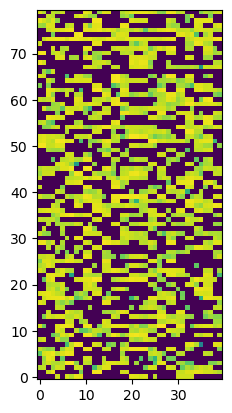

In [ ]:
#| hide
show_mel(mel[0])

In [ ]:
import nbdev; nbdev.nbdev_export()